In [2]:
# Generic libraries
import math
import numpy as np
import pandas as pd
import scipy as sp
import tqdm
import seaborn as sns
from itertools import product
import inspect
import multiprocessing
import time
import os
from pathlib import Path
import glob
import ipympl
from scipy.ndimage.filters import uniform_filter1d

from ipywidgets import *
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from IPython.core.pylabtools import figsize
from matplotlib import rc


/tmp/ipykernel_12989/1619004956.py:16: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [3]:
## plot settings
plt.style.use('seaborn-deep')
heat_cmap = 'viridis'
matplotlib.rcParams["axes.formatter.useoffset"] = False

In [4]:
# MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import diffusionmap, align, rms
from MDAnalysis.coordinates.base import Timestep
from MDAnalysis.analysis import contacts
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
import MDAnalysis.analysis.hydrogenbonds as hb

/home/kryohi/.miniconda3/envs/mdanal/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/home/kryohi/.miniconda3/envs/mdanal/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [5]:
## autocorrelation estimate
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [14]:
## Import common data (e.g. pdb and psf files)

nodna = False

if nodna:
    simdir = Path('../data/00-external_nodna/')
    PDB = simdir / '5Y36_nodna.pdb'
    GRO = simdir / '5Y36_nodna_box.gro'
    trajdir = '../data/04-prod_nodna/'
    TPR = trajdir + 'cas9_prod0_pyff.tpr' # use convert-tpr to delete the solvent from the tpr topology

else:
    simdir = Path('../data/00-external/')
    PDB = simdir / '5Y36.pdb'
    GRO = simdir / '5Y36_box.gro'
    trajdir = '../data/04-prod/'
    TPR = trajdir + 'cas9_prod0_pyff.tpr' # use convert-tpr to delete the solvent from the tpr topology


# set paths for output
plotpath = "../plots/"
datapath = "../data/analysis/"

if nodna:
    output_name = "prod_nodna_"
else:
    output_name = "prod_"

In [15]:
## import full trajectory data 
XTC  = trajdir + 'cas9_prod_pbc_all.xtc'

## universe creation
u = mda.Universe(str(TPR), str(XTC))
#u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u.select_atoms("not name W NA CL").n_atoms, 'system atoms')

# other info
box = u.dimensions
print('box dimensions:', box)
nframes = u.trajectory.n_frames
print(nframes, 'frames')
dt = u.trajectory.dt # ns per frame, equal to nstxout*0.002
dt_ns = dt / 1000
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(t_ns[-1], 'ns')


28303 system atoms
box dimensions: [183.38486  183.38486  183.38478   60.000008  60.000008  90.      ]
15401 frames
770.0 ns


In [16]:
## we import the equilibrated trajectory, with the first tot ns (it's in the filename) cut out
if nodna:
    XTC_cut = trajdir + 'cas9_prod_pbc_250cut.xtc'
else:
    XTC_cut = trajdir + 'cas9_prod_pbc_205cut.xtc'
## universe creation
u_cut = mda.Universe(str(TPR), str(XTC_cut))
time_cut = np.arange(0, dt*u_cut.trajectory.n_frames, dt)
t_ns_cut = time_cut / 1000
print(t_ns_cut[-1], 'ns')


565.0 ns


In [13]:
# Domain definitions
HNH = 'protein and resid 779 to 905'
RUVC = 'protein and resid 1 to 55 or resid 717 to 764 or resid 917 to 1098'
CTD = 'protein and resid 1098 to 1360' #1367 is the true C-terminus
REC = 'protein and resid 93 to 717'


## RMSD



In [9]:

stride = 1
reduced_index = list(range(0, nframes, stride))
ref_start = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[0:1]][0]

rmsd_ca = [rmsd(u.select_atoms('protein and name CA').positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_ca = np.array(rmsd_ca[1:-1])


<IPython.core.display.Javascript object>


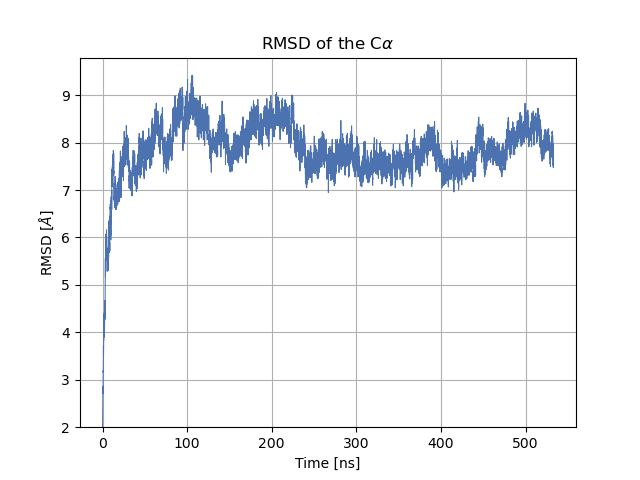

In [10]:
# plot of the backbone RMSD
fig = plt.figure()

plt.plot(t_ns[stride:-1:stride], rmsd_ca, lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of the C$\alpha$')
plt.ylim(bottom=2)
plt.grid()
#plt.legend()
#plt.autoscale(tight=True)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_ca.pdf'))

#### RMSD withe discarded part of the trajectory

5657
250.0


<IPython.core.display.Javascript object>


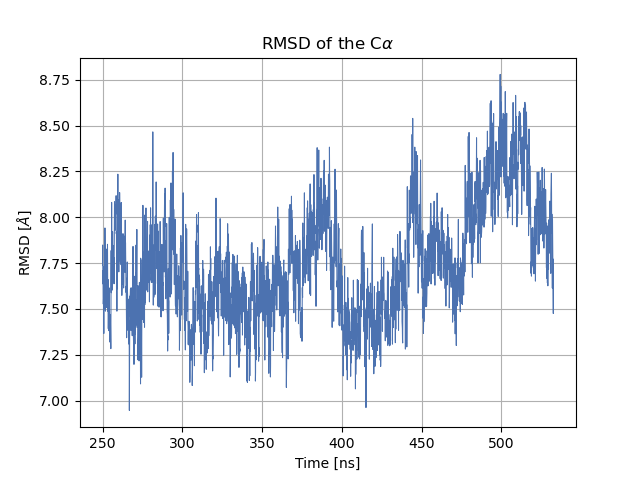

In [11]:
if nodna:
    startframe = 5000
else:
    startframe = 3120
print(nframes-startframe)
print(startframe*dt_ns)

# plot of the backbone RMSD
fig = plt.figure()

plt.plot(t_ns[startframe//stride:-3:2], rmsd_ca[startframe//stride:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of the C$\alpha$')
#plt.ylim(bottom=2)
plt.grid()
#plt.legend()
#plt.autoscale(tight=True)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_ca_cut.pdf'))

67.04841814680347


<IPython.core.display.Javascript object>


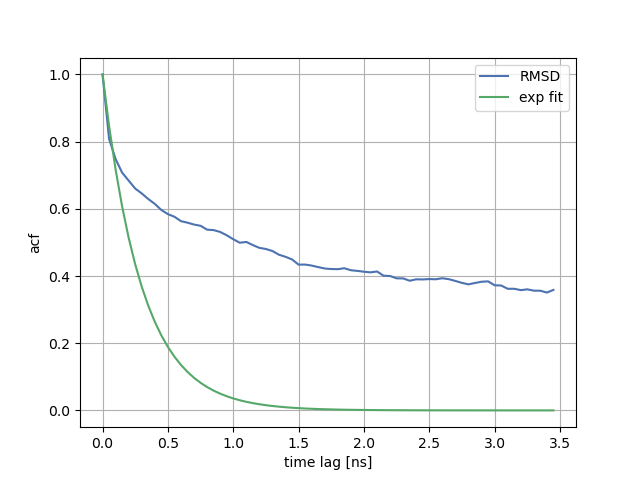

In [68]:

t_acf = t_ns[0:(len(t_ns)-startframe)//(2*stride)] * stride  
acf = autocorrelation(rmsd_ca[startframe:-1])[0:(len(rmsd_ca)-startframe)//2]
act = sum(acf[0:len(acf)//10])
print(act)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf[0:70], acf[0:70], label=r"RMSD")
ax.plot(t_acf[0:70], np.exp(-t_acf[0:70]/0.3), label=r"exp fit")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_acf_cut.pdf'))

In [12]:
## RMSD of the DNA and RNA phosphates (not really useful since parts of these are outside of the protein)
stride = 5
reduced_index = list(range(1, nframes, stride))

ref_start = [u.select_atoms('(nucleic and name P)').positions \
             for ts in u.trajectory[0:1]][0]

rmsd_bn = [rmsd(u.select_atoms('(nucleic and name P)').positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]


<IPython.core.display.Javascript object>


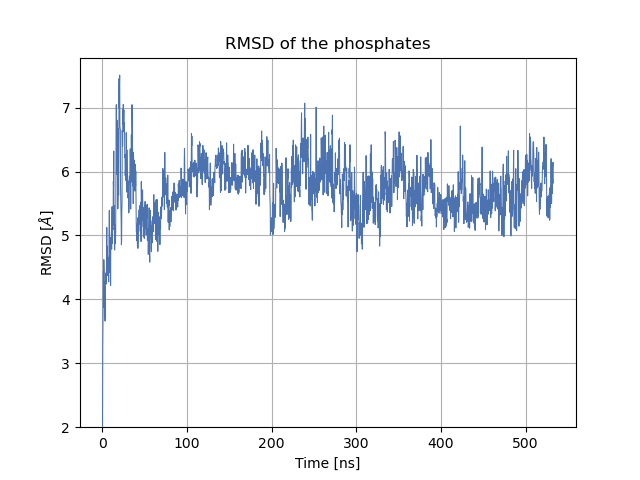

In [13]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:stride], rmsd_bn[0:-1], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of the phosphates')
plt.ylim(bottom=2)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_nucleic.pdf'))

### RMSD of  interesting protein domains

In [14]:
stride = 1
reduced_index = list(range(0, nframes, stride))
closeatoms = 'protein and same residue as ((around 7 name P O1P O2P) and (around 15 name MG))'
atoms = [u.select_atoms(closeatoms) for ts in u.trajectory[0:1]][0]
ref_start = [atoms.positions for ts in u.trajectory[0:1]][0]

rmsd_inside = [rmsd(atoms.positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_inside = np.array(rmsd_inside[0:-1])

<IPython.core.display.Javascript object>


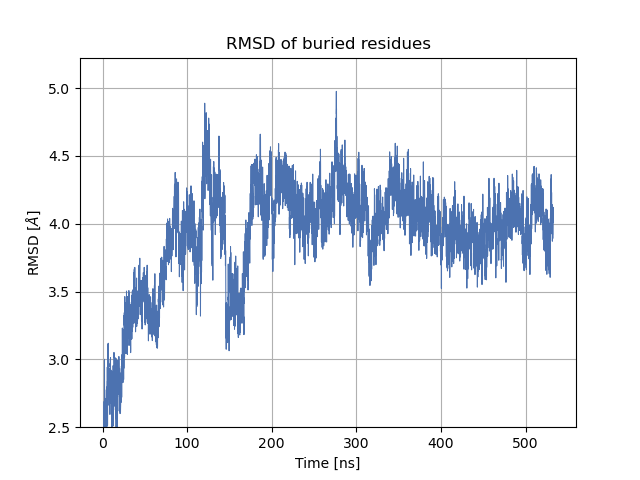

In [15]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:2], rmsd_inside[0:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of buried residues')
plt.ylim(bottom=2.5)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_buriedresidues.pdf'))

In [16]:
stride = 1
reduced_index = list(range(0, nframes, stride))
atoms = [u.select_atoms(HNH) for ts in u.trajectory[0:1]][0]
ref_start = [atoms.positions for ts in u.trajectory[0:1]][0]

rmsd_HNH = [rmsd(atoms.positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_HNH = np.array(rmsd_HNH[0:-1])

<IPython.core.display.Javascript object>


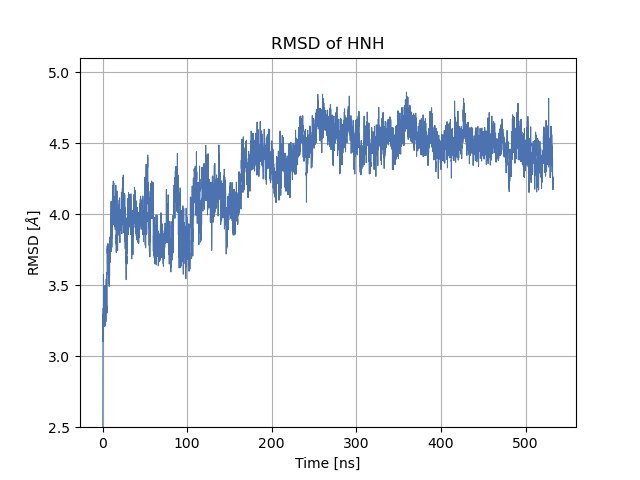

In [17]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:2], rmsd_HNH[0:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of HNH')
plt.ylim(bottom=2.5)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_HNH.pdf'))

79.48272652235312


<IPython.core.display.Javascript object>


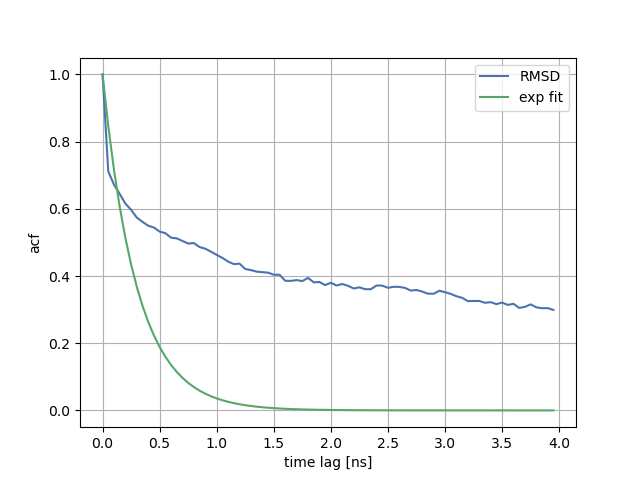

In [39]:

t_acf = t_ns[0:(len(t_ns)-startframe)//(2*stride)] * stride  
acf = autocorrelation(rmsd_HNH[startframe:-1])[0:(len(rmsd_HNH)-startframe)//2]
act = sum(acf[0:len(acf)//10])
print(act)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf[0:80], acf[0:80], label=r"RMSD")
ax.plot(t_acf[0:80], np.exp(-t_acf[0:80]/0.3), label=r"exp fit")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_acf_HNH_cut.pdf'))

In [18]:
stride = 2
reduced_index = list(range(0, nframes, stride))
atoms = [u.select_atoms(CTD) for ts in u.trajectory[0:1]][0]
ref_start = [atoms.positions for ts in u.trajectory[0:1]][0]

rmsd_CTD = [rmsd(atoms.positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_CTD = np.array(rmsd_CTD[0:-1])

<IPython.core.display.Javascript object>


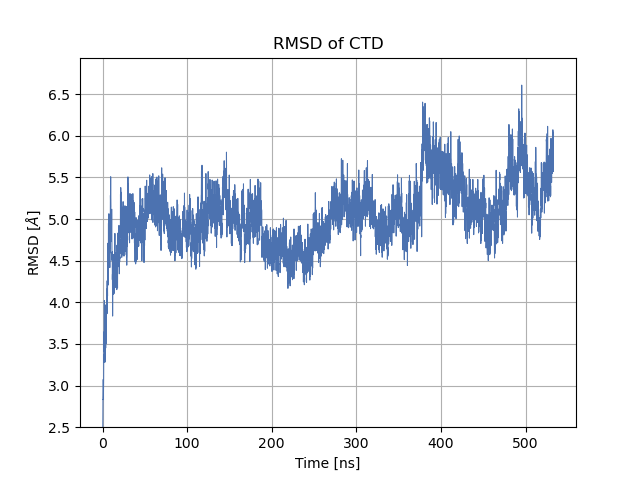

In [19]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:2], rmsd_CTD[0:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of CTD')
plt.ylim(bottom=2.5)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_CTD.pdf'))

In [20]:
stride = 1
reduced_index = list(range(0, nframes, stride))
atoms = [u.select_atoms(REC) for ts in u.trajectory[0:1]][0]
ref_start = [atoms.positions for ts in u.trajectory[0:1]][0]

rmsd_REC = [rmsd(atoms.positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_REC = np.array(rmsd_REC[0:-1])

<IPython.core.display.Javascript object>


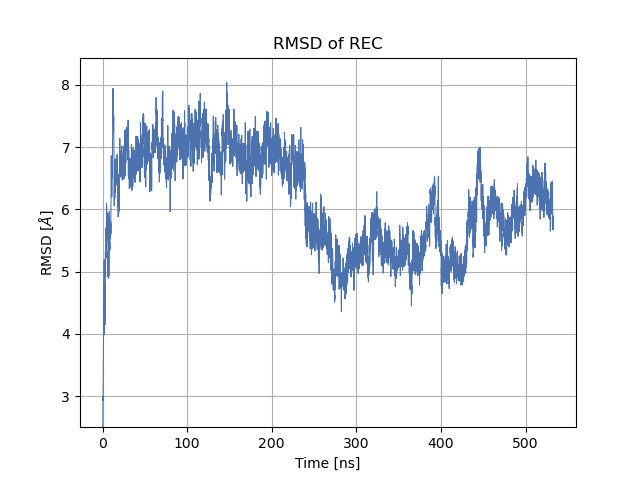

In [21]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:2], rmsd_REC[0:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of REC')
plt.ylim(bottom=2.5)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_REC.pdf'))

In [22]:
stride = 1
reduced_index = list(range(0, nframes, stride))
atoms = [u.select_atoms(RUVC) for ts in u.trajectory[0:1]][0]
ref_start = [atoms.positions for ts in u.trajectory[0:1]][0]

rmsd_RUVC = [rmsd(atoms.positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]

rmsd_RUVC = np.array(rmsd_RUVC[0:-1])

<IPython.core.display.Javascript object>


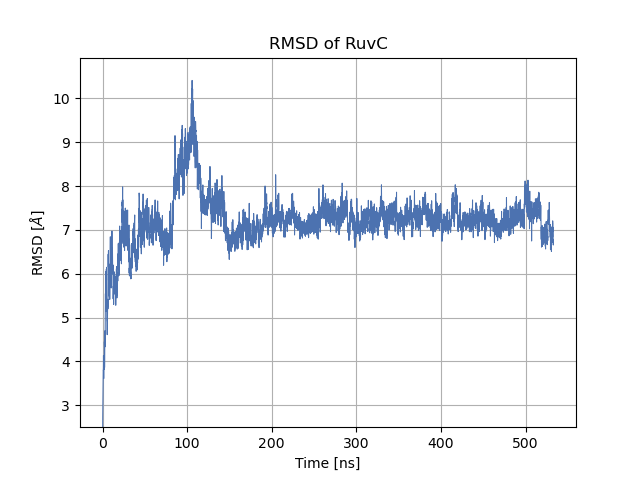

In [23]:
fig = plt.figure()

plt.plot(t_ns[stride:-1:2], rmsd_RUVC[0:-1:2], lw=0.75)

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of RuvC')
plt.ylim(bottom=2.5)
plt.grid()
#plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_RUVC.pdf'))

### Comparison 

<IPython.core.display.Javascript object>


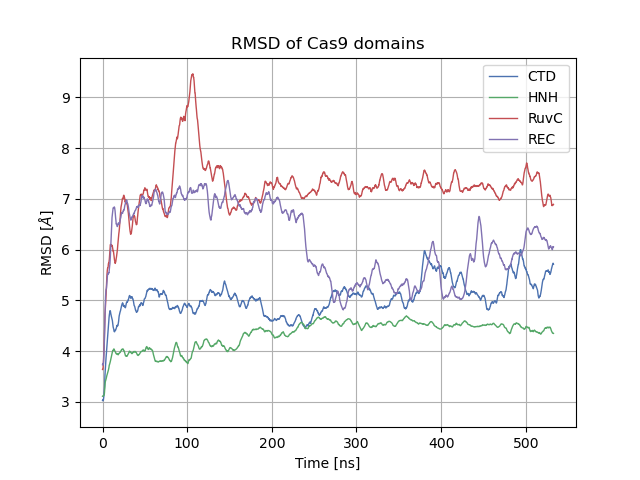

In [24]:
fig = plt.figure()

plt.plot(t_ns[1:-2:2], uniform_filter1d(rmsd_CTD[0:-1:1], size=100)[0:-1:2], lw=1, label='CTD')
plt.plot(t_ns[1:-2:2], uniform_filter1d(rmsd_HNH[0:-1:1], size=100)[0:-1:2], lw=1, label='HNH')
plt.plot(t_ns[1:-2:2], uniform_filter1d(rmsd_RUVC[0:-1:1], size=100)[0:-1:2], lw=1, label='RuvC')
plt.plot(t_ns[1:-2:2], uniform_filter1d(rmsd_REC[0:-1:1], size=100)[0:-1:2], lw=1, label='REC')

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.title(r'RMSD of Cas9 domains')
plt.ylim(bottom=2.5)
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_comparison.pdf'))

## RMSD 2D Map

In [25]:
step = 10
aligner = align.AlignTraj(u, u, select='name CA', in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u, select='name CA').run(start=200, step=step)

<IPython.core.display.Javascript object>


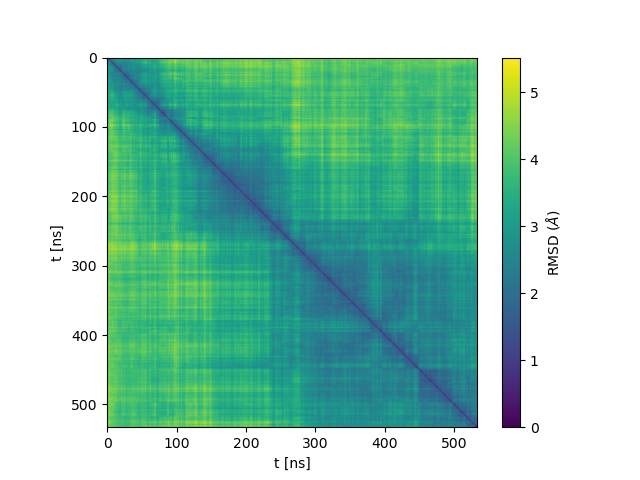

In [26]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap='viridis', extent=[0,t_ns[-1],t_ns[-1],0])
plt.xlabel('t [ns]')
plt.ylabel('t [ns]')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map.pdf'))
plt.show()

121206


<IPython.core.display.Javascript object>


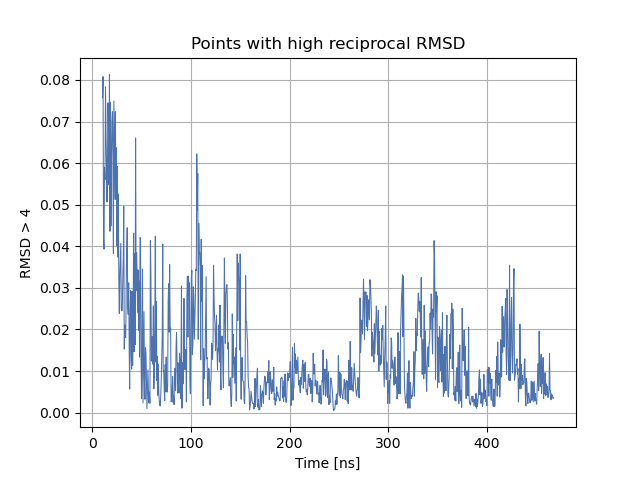

In [84]:
cutoff = 4
bool_arr = matrix.results.dist_matrix>cutoff
high_rmsd_positions = np.where(bool_arr)[0]
print(len(high_rmsd_positions))
sum_rmsd = np.sum(bool_arr, axis=1) / nframes

plt.figure()
plt.clf()
plt.plot(t_ns[200+step:-1:step], sum_rmsd[0:-1:1], lw=0.75)
plt.xlabel('Time [ns]')
plt.ylabel(f'RMSD > {cutoff}')
plt.title(r'Points with high reciprocal RMSD')
plt.grid()
#plt.legend()
plt.show()


TODO check what happens at 150ns by comparing averaged 2 frames

### Cut trajectory

In [27]:
step = 5
aligner = align.AlignTraj(u_cut, u_cut, select='name CA', in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u_cut, select='name CA').run(start=0, step=step)

<IPython.core.display.Javascript object>


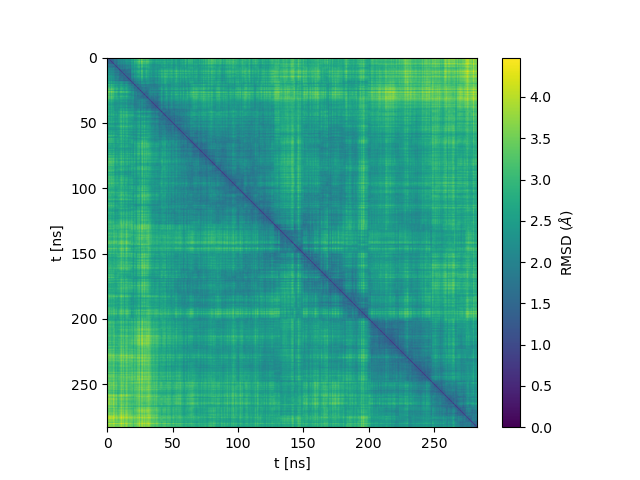

In [28]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap='viridis', interpolation='Lanczos',
           extent=[0,t_ns_cut[-1],t_ns_cut[-1],0])
plt.xlabel('t [ns]')
plt.ylabel('t [ns]')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map_cut.pdf'))
plt.show()

7686


<IPython.core.display.Javascript object>


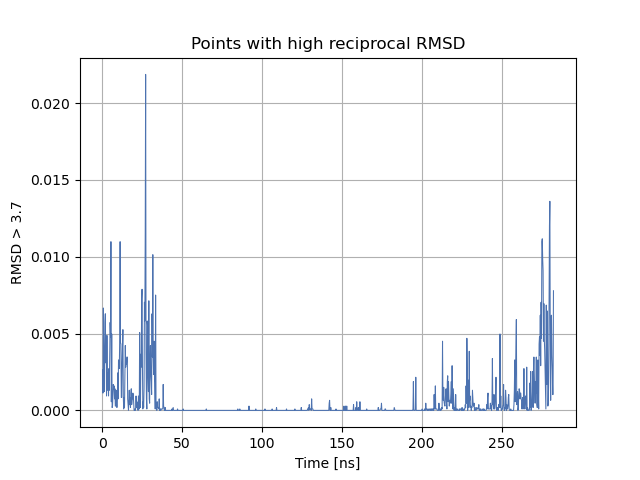

In [29]:
cutoff = 3.7
bool_arr = matrix.results.dist_matrix>cutoff
high_rmsd_positions = np.where(bool_arr)[0]
print(len(high_rmsd_positions))
sum_rmsd = np.sum(bool_arr, axis=1) / nframes

plt.figure()
plt.clf()
plt.plot(t_ns_cut[1:-1:step], sum_rmsd[0:-1], lw=0.75)
plt.xlabel('Time [ns]')
plt.ylabel(f'RMSD > {cutoff}')
plt.title('Points with high reciprocal RMSD')
plt.grid()
#plt.legend()
plt.show()


### RMSD Map of HNH and CTD domains

In [30]:
step = 10
aligner = align.AlignTraj(u_cut, u_cut, select=HNH, in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u_cut, select=HNH).run(start=0, step=step)

<IPython.core.display.Javascript object>


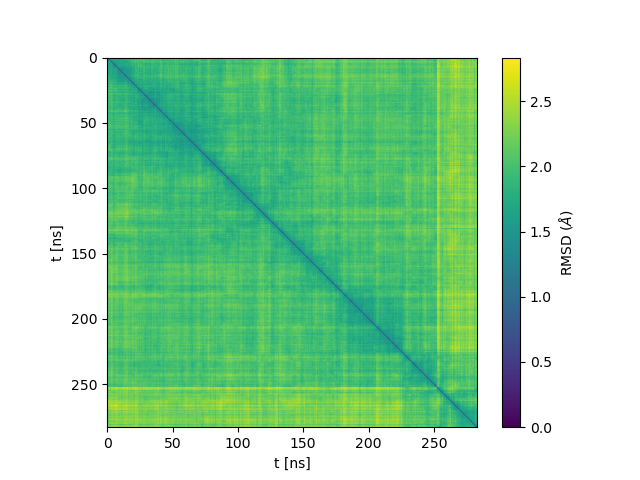

In [31]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap='viridis', interpolation='Lanczos',
           extent=[0,t_ns_cut[-1],t_ns_cut[-1],0])
plt.xlabel('t [ns]')
plt.ylabel('t [ns]')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map_cut_HNH.pdf'))
plt.show()

In [32]:
aligner = align.AlignTraj(u_cut, u_cut, select=CTD, in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u_cut, select=CTD).run(start=0, step=step)

<IPython.core.display.Javascript object>


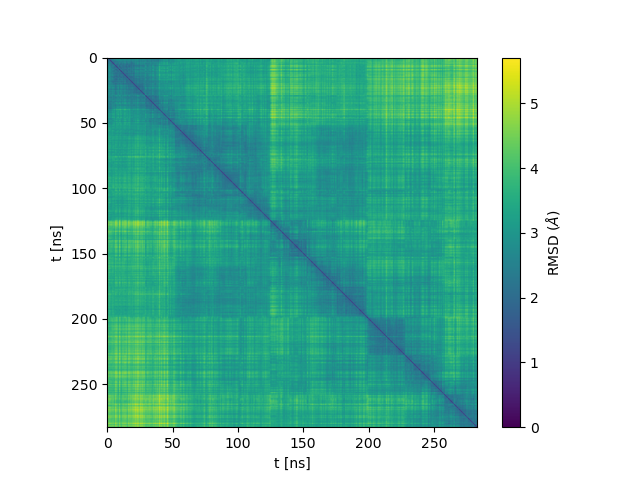

In [33]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap='viridis', interpolation='Lanczos',
           extent=[0,t_ns_cut[-1],t_ns_cut[-1],0])
plt.xlabel('t [ns]')
plt.ylabel('t [ns]')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map_cut_CTD.pdf'))
plt.show()

In [34]:
aligner = align.AlignTraj(u_cut, u_cut, select=RUVC, in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u_cut, select=RUVC).run(start=0, step=step)

<IPython.core.display.Javascript object>


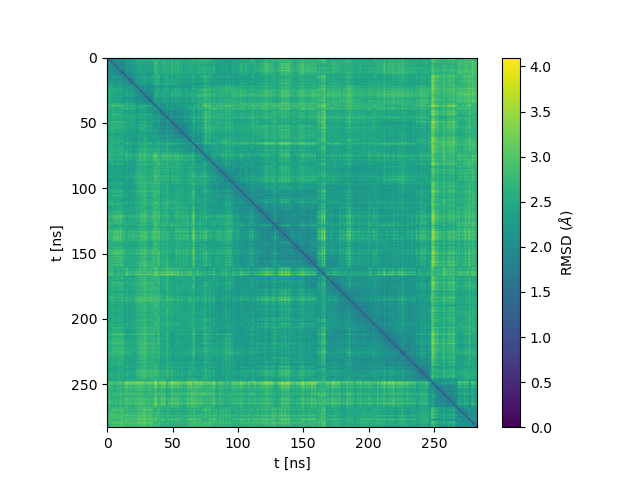

In [35]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap='viridis', interpolation='Lanczos',
           extent=[0,t_ns_cut[-1],t_ns_cut[-1],0])
plt.xlabel('t [ns]')
plt.ylabel('t [ns]')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map_cut_RuvC.pdf'))
plt.show()

In [36]:
aligner = align.AlignTraj(u_cut, u_cut, select=REC, in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u_cut, select=REC).run(start=0, step=step)

<IPython.core.display.Javascript object>


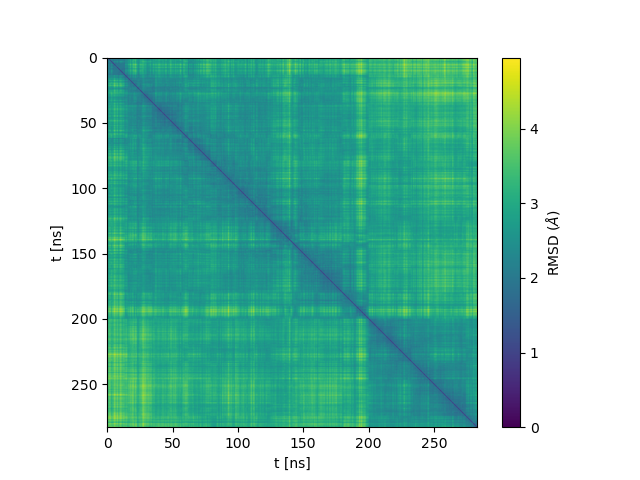

In [37]:
plt.figure()
plt.imshow(matrix.results.dist_matrix, cmap=heat_cmap, interpolation='Lanczos',
           extent=[0,t_ns_cut[-1],t_ns_cut[-1],0])
plt.xlabel('t [ns]')
plt.ylabel('t [ns]')
plt.colorbar(label=r'RMSD ($\AA$)')
plt.savefig(os.path.join(plotpath, output_name+'rmsd_map_cut_REC.pdf'))
plt.show()

## RMSF


$$RMSF_i = \left[\frac{1}{T}\sum_{t_j=1}^T |\mathbf{r}_i(t_j)-\mathbf{r}_i|^2\right]^{1/2}$$


In [41]:
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import align
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction

In [52]:
average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=1).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

In [53]:
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas, verbose=True).run()

  0%|          | 0/10657 [00:00<?, ?it/s]

/tmp/ipykernel_9724/1722627788.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure()


<IPython.core.display.Javascript object>


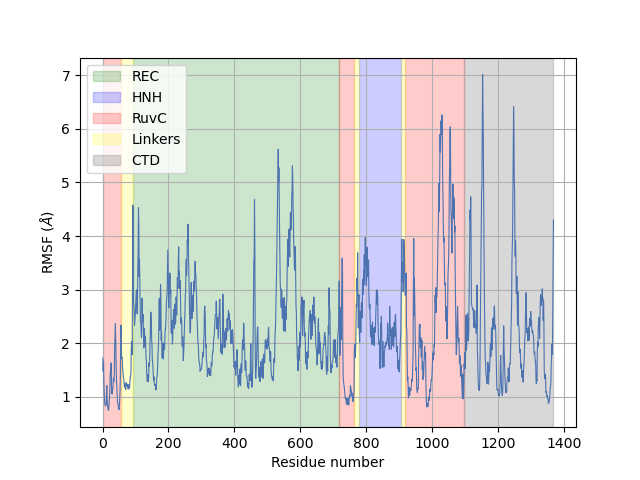

In [58]:
fig2 = plt.figure()
plt.plot(c_alphas.resids, R.results.rmsf, lw=0.8)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(93, 717, zorder=0, alpha=0.2, color='green', label='REC')
plt.axvspan(779, 905, zorder=0, alpha=0.2, color='blue', label='HNH')
plt.axvspan(0, 55, zorder=0, alpha=0.2, color='red', label='RuvC')
plt.axvspan(717, 764, zorder=0, alpha=0.2, color='red')
plt.axvspan(917, 1098, zorder=0, alpha=0.2, color='red')
plt.axvspan(764, 779, zorder=0, alpha=0.2, color='yellow', label='Linkers')
plt.axvspan(905, 917, zorder=0, alpha=0.2, color='yellow')
plt.axvspan(56, 92, zorder=0, alpha=0.2, color='yellow')
plt.axvspan(1098, 1367, zorder=0, alpha=0.3, color='grey', label='CTD')

plt.legend();
plt.grid();
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsf_ca.pdf'))

In [58]:
bool_arr = R.results.rmsf>4
high_rmsf_positions = np.where(bool_arr)[0]
print(high_rmsf_positions)

[  91   92  107  108  109  258  460  461  529  530  531  532  533  534
  535  536  561  564  565  568  569  570  571  572  573  574  575  576
  577  578  579  726  773  796  801  802  913 1016 1017 1018 1019 1020
 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034
 1035 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061
 1062 1063 1064 1065 1066 1067 1068 1114 1115 1116 1117 1149 1150 1151
 1152 1153 1154 1155 1243 1244 1245 1246 1247 1248 1249 1250 1252 1367]


In [59]:
u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
protein = u.select_atoms('protein') # select protein atoms
for residue, r_value in zip(protein.residues, R.results.rmsf):
    residue.atoms.tempfactors = r_value
    #print(residue.atoms.tempfactors)

In [60]:
# suppress some MDAnalysis warnings about writing PDB files
import warnings
warnings.filterwarnings('ignore')
# save pdb with beta factor data
u.atoms.write(os.path.join(datapath, 'rmsf_tempfactors0-40.pdb')) #writes pdb with the beta factors to analysis

In [74]:
import nglview as nv
view = nv.show_mdanalysis(u)
view.update_representation(color_scheme='bfactor')
view

NGLWidget(max_frame=4100)

In [61]:
rmsf1 = RMSF(c_alphas, start=1, stop=nframes//4).run(start=1, stop=nframes//4)
rmsf2 = RMSF(c_alphas, start=nframes//4, stop=nframes//2).run(start=nframes//4, stop=nframes//2)
rmsf3 = RMSF(c_alphas, start=nframes//2, stop=3*nframes//4).run(start=nframes//2, stop=3*nframes//4)
rmsf4 = RMSF(c_alphas, start=3*nframes//4, stop=nframes-1).run(start=3*nframes//4, stop=nframes-1)

<IPython.core.display.Javascript object>


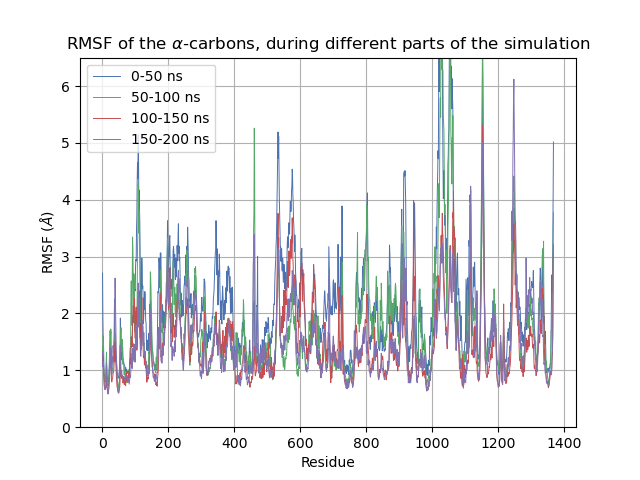

In [62]:
fig = plt.figure()
plt.plot(c_alphas.resnums, rmsf1.results.rmsf, lw=0.7, label='0-50 ns')
plt.plot(c_alphas.resnums, rmsf2.results.rmsf, lw=0.7, label='50-100 ns')
plt.plot(c_alphas.resnums, rmsf3.results.rmsf, lw=0.7, label='100-150 ns')
plt.plot(c_alphas.resnums, rmsf4.results.rmsf, lw=0.7, label='150-200 ns')
#plt.axvline(x=59, color='r', lw=0.8)
plt.ylim(top=6.5, bottom=0)
#plt.xlim(left=0)
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons, during different parts of the simulation')
plt.grid()
plt.legend(loc=0)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsf_part.pdf'))

In [77]:
bool_arr = rmsf2.results.rmsf>3.5
high_rmsf_positions = np.where(bool_arr)[0]
print(high_rmsf_positions)

[ 106  107  108  109  197 1017 1018 1019 1020 1021 1022 1023 1024 1025
 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1047 1048
 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062
 1063 1068 1114 1116 1149 1150 1151 1152 1153 1154 1155 1367]


#### RMSF of the equilibrated (cut) trajectory

In [46]:
average = align.AverageStructure(u_cut, u_cut, select='protein and name CA', ref_frame=1).run()
ref = average.results.universe
aligner = align.AlignTraj(u_cut, ref, select='protein and name CA', in_memory=True).run()

In [47]:
c_alphas = u_cut.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas, verbose=True).run()

  0%|          | 0/5657 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


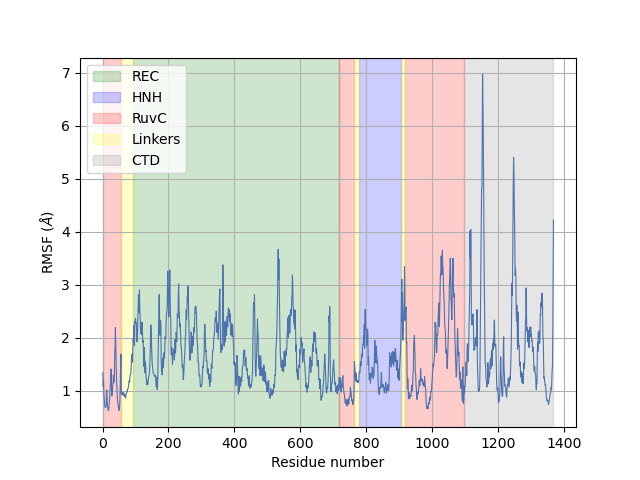

In [51]:
fig4 = plt.figure()
plt.plot(c_alphas.resids, R.results.rmsf, lw=0.8)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(93, 717, zorder=0, alpha=0.2, color='green', label='REC')
plt.axvspan(779, 905, zorder=0, alpha=0.2, color='blue', label='HNH')
plt.axvspan(0, 55, zorder=0, alpha=0.2, color='red', label='RuvC')
plt.axvspan(717, 764, zorder=0, alpha=0.2, color='red')
plt.axvspan(917, 1098, zorder=0, alpha=0.2, color='red')
plt.axvspan(764, 779, zorder=0, alpha=0.2, color='yellow', label='Linkers')
plt.axvspan(905, 917, zorder=0, alpha=0.2, color='yellow')
plt.axvspan(56, 92, zorder=0, alpha=0.2, color='yellow')
plt.axvspan(1098, 1367, zorder=0, alpha=0.2, color='grey', label='CTD')

plt.legend();
plt.grid();
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsf_ca_cut.pdf'))

In [49]:
bool_arr = R.results.rmsf>4
high_rmsf_positions = np.where(bool_arr)[0]
print(high_rmsf_positions)

[1114 1116 1148 1149 1150 1151 1152 1153 1154 1155 1156 1244 1245 1246
 1247 1248 1249 1367]


#### average_prot = align.AverageStructure(u, u, select='protein', ref_frame=1).run()
ref_prot = average_prot.results.universe

In [78]:
# Save aligned trajectory
#aligner = align.AlignTraj(u, ref_prot,
#                           select='protein',
#                           filename='./data/analysis/aligned_prot.dcd',
#                           in_memory=False).run()
#prot_al = u.select_atoms("protein")
#prot_al.write(os.path.join(datapath,'aligned_prot.xtc'), frames='all')


## Radius of gyration

$$R_\mathrm{gyr} = \sqrt{\frac{1}{M}\sum_{i=1}^{N} m_i(\mathbf{r}_i - \mathbf{R})^2}$$

In [55]:
stride = 1
Rgyr = []
ca = u.select_atoms("protein and name CA")
for ts in u.trajectory[0:nframes:stride]:
   Rgyr.append(ca.radius_of_gyration())
Rgyr = np.array(Rgyr)

rel_diff = (max(Rgyr) - min(Rgyr))/10
print(len(ca))

1368


/tmp/ipykernel_9724/4093479229.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


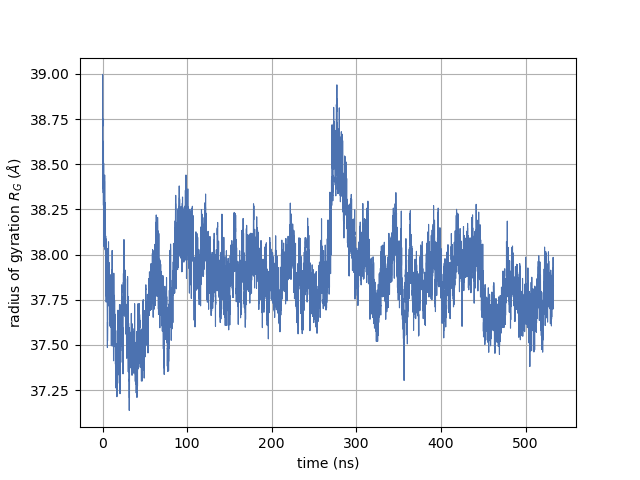

In [59]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_ns[0:nframes:stride], Rgyr, lw=0.8, label=r"$R_G$")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
plt.grid()
plt.show()
ax.figure.savefig(plotpath+output_name+"Rgyr_ca.pdf")

/tmp/ipykernel_9724/165602352.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


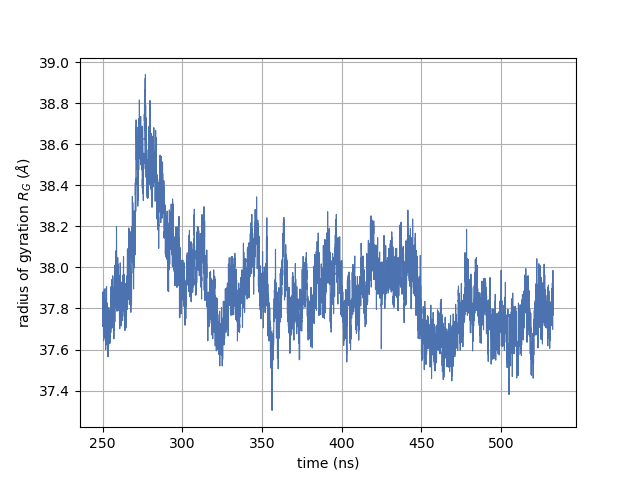

In [60]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_ns[startframe:nframes-1:stride], Rgyr[startframe:-1], lw=0.8, label=r"$R_G$")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
plt.grid()
plt.show()
ax.figure.savefig(plotpath+output_name+"Rgyr_ca_cut.pdf")

/tmp/ipykernel_17815/3329129437.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


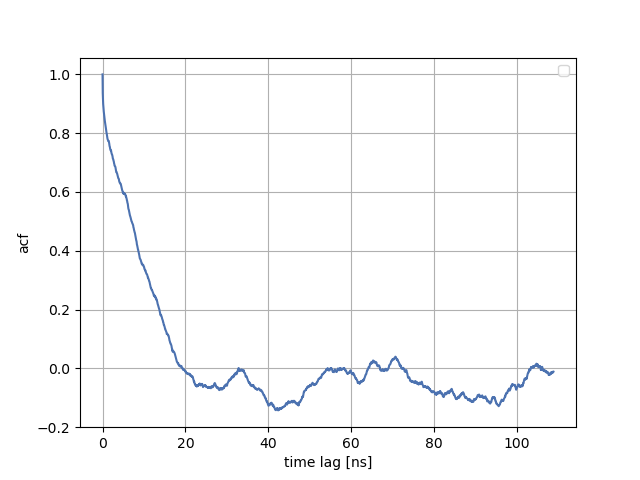

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [78]:
#startframe = 3120

t_acf = t_ns[0:(len(t_ns)-startframe)//(2*stride)] * stride  
acf = autocorrelation(Rgyr[startframe:-1])[0:(len(Rgyr)-startframe)//2]
act = sum(acf[0:len(acf)//6])

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf, acf)
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rgyr_acf.pdf'))

In [83]:
act

16.674563156496387

## Block average analysis

In [37]:
def blocked(universe, u_selection, blocklength, startframe, analyze):
    #size = (universe.trajectory.n_frames - startframe) // nblocks
    nblocks = math.floor((universe.trajectory.n_frames - startframe) / blocklength)
    blocks_avg = []
    blocks_std = []
    
    for block in range(nblocks):
        val = []
        for ts in universe.trajectory[startframe+block*blocklength : startframe+(block+1)*blocklength]:
            val.append(analyze(u_selection))
        blocks_avg.append(np.average(val))
        blocks_std.append(np.std(val))
    blockaverage = np.average(blocks_avg)
    blockstd = np.std(blocks_avg) #/  math.sqrt(nblocks)
    #blockstd = np.average(blocks_std)

    return nblocks, blocklength, blockaverage, blockstd


In [38]:
def rgyr(selection):
    return selection.radius_of_gyration()

In [39]:
rgyr_5blocks = blocked(u, ca, 5, 1, rgyr)
rgyr_5blocks

(2060, 5, 37.90815541285271, 0.17492516627211746)

In [40]:
startframe = 3120
ca = u.select_atoms("protein and name CA")
#nblocks_array = [60,70,80,100,150,220,300,400,595,836,1045,1393,2090]
block_lengths = [2,3,4,5,7,8,10,15,20,25,30,40,50,60,70,80,100,120]
results = []
for blocks in block_lengths:
    results.append(blocked(u, ca, blocks, startframe, rgyr))
rg = np.array(results)

In [41]:
#block_lengths = (nframes-startframe) / np.array(nblocks_array)
print(nframes-startframe)
rg[:,3]

7181


array([0.14777804, 0.14598017, 0.14467376, 0.14355568, 0.14243168,
       0.14173364, 0.14075378, 0.13887517, 0.13743826, 0.13683396,
       0.13561635, 0.1346451 , 0.13340332, 0.13186968, 0.13146418,
       0.13109261, 0.1308232 , 0.12953553])

<IPython.core.display.Javascript object>


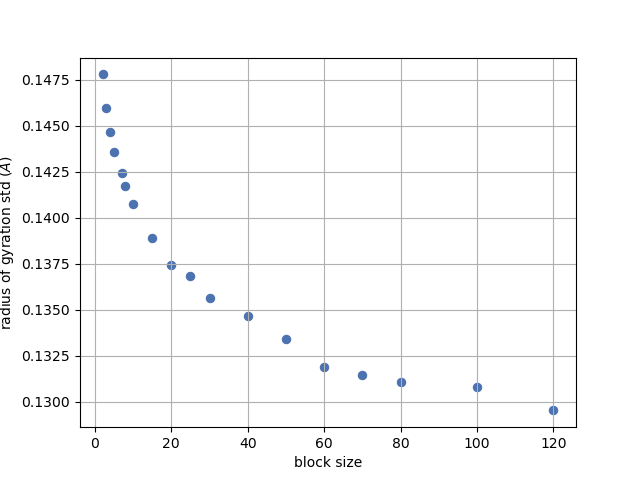

In [42]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(block_lengths, rg[:,3], lw=0.8, label=r"$R_G$")
ax.set_xlabel("block size")
ax.set_ylabel(r"radius of gyration std ($\AA$)")
plt.grid()
plt.show()


In [43]:
6*dt_ns

0.30000000000000004

<IPython.core.display.Javascript object>


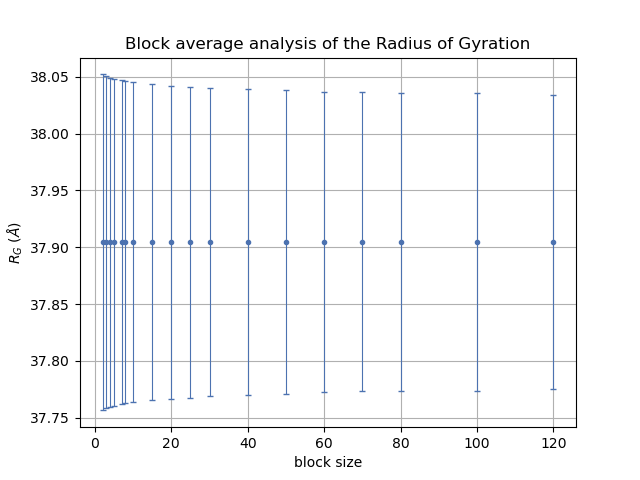

In [44]:
fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(block_lengths, rg[:,2], rg[:,3], lw=0.8, marker='.', label=r"$RMSD$", capsize=2.5, linestyle='')
ax.set_xlabel("block size")
ax.set_ylabel(r"$R_G$ ($\AA$)")
plt.title("Block average analysis of the Radius of Gyration")
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rgyr_block_fixed.pdf'))

In [45]:
ref_start = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[0:1]][0]

def rmsd_block(selection):
    return rmsd(selection.positions, ref_start, center=True, superposition=True)


In [46]:
block_lengths = [2,3,4,5,7,8,10,15,20,25,30,40,50,60,70,80,100,120]
results = []
for blocks in block_lengths:
    results.append(blocked(u, ca, blocks, startframe, rmsd_block))
rmsd = np.array(results)

<IPython.core.display.Javascript object>


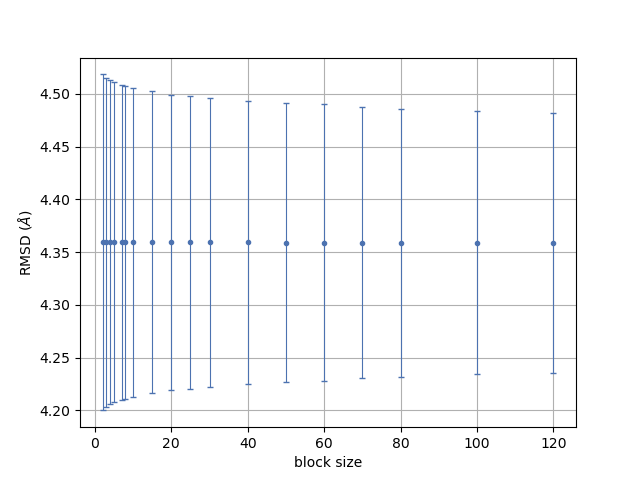

In [48]:
fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(block_lengths, rmsd[:,2], rmsd[:,3], lw=0.8, marker='.', label=r"$RMSD$", capsize=2.5, linestyle='')
ax.set_xlabel("block size")
ax.set_ylabel(r"RMSD ($\AA$)")
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'rmsd_block.pdf'))

## Distances

distance between the PAM and the arginine residues that recognise it

In [60]:
# center of mass of the Arginine
arg3_all = u.select_atoms('resid 1333 and resname ARG and name NH1 NH2') #1333-1531 altra coppia
lys_all = u.select_atoms('resid 1334 and resname LYS and name NZ CE CD ') #1333-1531 altra coppia
arg5_all = u.select_atoms('resid 1335 and resname ARG and name NH1 NH2') #1333-1531 altra coppia
arg3 = u.select_atoms('resid 1333 and resname ARG and name NH1') #1333-1531 altra coppia
arg5 = u.select_atoms('resid 1335 and resname ARG and name NH1') #1333-1531 altra coppia
n_arg = len(arg3_all)
n_lys = len(lys_all)

#arg3_cdm = np.array([arg3_all.center_of_mass() for ts in u.trajectory[:]])
#arg5_cdm = np.array([arg5_all.center_of_mass() for ts in u.trajectory[:]])


In [61]:
# guanine
G3_all = u.select_atoms('resid 1481 and resname DG and name C6 C4 O6') # resid 1480/1481
G5_all = u.select_atoms('resid 1482 and resname DG and name C6 C4 O6')
G3 = u.select_atoms('resnum 38 and resname DG and name C6') #c6
G5 = u.select_atoms('resnum 39 and resname DG and name C6')
n_G = len(G3_all)
#G3_cdm = np.array([G3_all.center_of_mass() for ts in u.trajectory[:]])
#G5_cdm = np.array([G5_all.center_of_mass() for ts in u.trajectory[:]])


In [64]:
dist_arr = distances.distance_array(lys_all.positions, # reference
                                    G5_all.positions, # configuration
                                    box=u.dimensions)
dist_arr.shape

(2, 3)

<IPython.core.display.Javascript object>


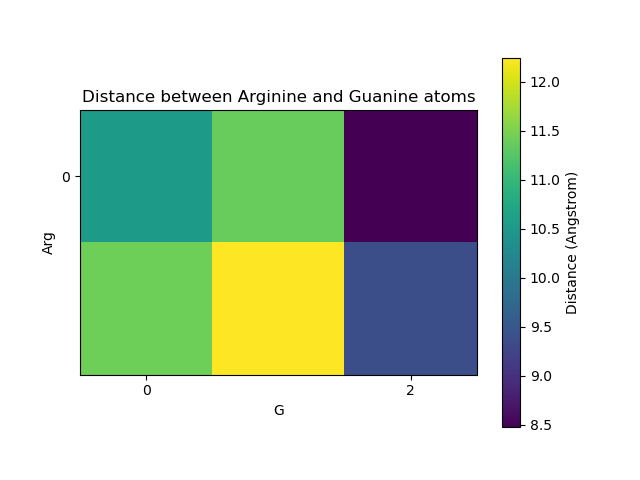

Text(0, 0.5, 'Distance (Angstrom)')

In [65]:
fig, ax = plt.subplots()
im = ax.imshow(dist_arr, origin='upper')

# add residue ID labels to axes
tick_interval = 2
ax.set_yticks(np.arange(n_lys)[::tick_interval])
ax.set_xticks(np.arange(n_G)[::tick_interval])
#ax.set_yticklabels(arg3_all.resids[::tick_interval])
#ax.set_xticklabels(G3_all.resids[::tick_interval])

# add figure labels and titles
plt.ylabel('Arg')
plt.xlabel('G')
plt.title('Distance between Arginine and Guanine atoms')

# colorbar
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Distance (Angstrom)')

In [25]:
dist_atoms_33 =  [distances.distance_array(arg3.positions, G3.positions, box=u.dimensions)[0][0]
               for ts in u.trajectory[3200:-1]]
dist_atoms_55 =  [distances.distance_array(arg5.positions, G5.positions, box=u.dimensions)[0][0]
               for ts in u.trajectory[3200:-1]]
print(np.mean(dist_atoms_33))
print(np.mean(dist_atoms_55))

5.759341702235298
5.873583705696939


In [26]:
dist_atoms_33_min =  [np.min(distances.distance_array(arg3_all.positions, G3_all.positions, box=u.dimensions))
               for ts in u.trajectory[3200:-1]]
dist_atoms_55_min =  [np.min(distances.distance_array(arg5_all.positions, G5_all.positions, box=u.dimensions))
               for ts in u.trajectory[3200:-1]]
print(np.mean(dist_atoms_33_min))
print(np.mean(dist_atoms_55_min))

5.052194266049706
5.679943499326851


In [27]:
np.min(distances.distance_array(arg3_all.positions, G3_all.positions, box=u.dimensions))

4.335529462796132

<IPython.core.display.Javascript object>


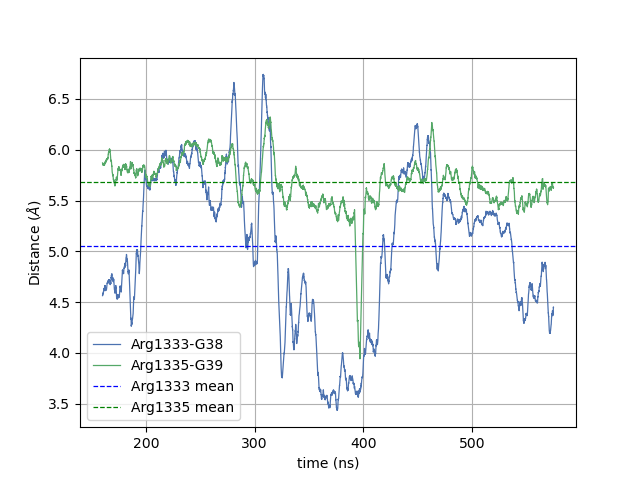

In [30]:
fig = plt.figure()
ax = plt.subplot(111)
#ax.plot(t_ns, uniform_filter1d(dist_atoms, size=100), lw=0.8, label=r"$R_G$")
ax.plot(t_ns[3200:-1], uniform_filter1d(dist_atoms_33_min, size=100), lw=0.9, label="Arg1333-G38")
ax.plot(t_ns[3200:-1], uniform_filter1d(dist_atoms_55_min, size=100), lw=0.9, label="Arg1335-G39")

plt.axhline(np.mean(dist_atoms_33_min), color='blue', label="Arg1333 mean", lw=0.9, ls='dashed')
plt.axhline(np.mean(dist_atoms_55_min), color='green', label="Arg1335 mean", lw=0.9, ls='dashed')

ax.set_xlabel("time (ns)")
ax.set_ylabel(r"Distance ($\AA$)")
plt.legend()
plt.grid()
plt.show()
ax.figure.savefig(plotpath+output_name+"dist_PAM.pdf")

In [66]:
dist_atoms_33_min = [np.min(distances.distance_array(lys_all.positions, G3_all.positions, box=u.dimensions))
               for ts in u.trajectory[3200:-1]]
dist_atoms_55_min = [np.min(distances.distance_array(lys_all.positions, G5_all.positions, box=u.dimensions))
               for ts in u.trajectory[3200:-1]]
print(np.mean(dist_atoms_33_min))
print(np.mean(dist_atoms_55_min))

9.833790804191876
12.234980837932156


In [175]:
u.select_atoms('resnum 39 and resname DG').names

array(['P', 'O1P', 'O2P', "O5'", "C5'", "H5'1", "H5'2", "C4'", "H4'",
       "O4'", "C1'", "H1'", 'N9', 'C8', 'H8', 'N7', 'C5', 'C6', 'O6',
       'N1', 'H1', 'C2', 'N2', 'H21', 'H22', 'N3', 'C4', "C3'", "H3'",
       "C2'", "H2'1", "H2'2", "O3'"], dtype=object)

In [11]:
u.select_atoms('resid 1333 and resname ARG').names

array(['N', 'H', 'CA', 'HA', 'CB', 'HB1', 'HB2', 'CG', 'HG1', 'HG2', 'CD',
       'HD1', 'HD2', 'NE', 'HE', 'CZ', 'NH1', 'HH11', 'HH12', 'NH2',
       'HH21', 'HH22', 'C', 'O'], dtype=object)

In [22]:
u.select_atoms('resid 1334').names

array(['N', 'H', 'CA', 'HA', 'CB', 'HB1', 'HB2', 'CG', 'HG1', 'HG2', 'CD',
       'HD1', 'HD2', 'CE', 'HE1', 'HE2', 'NZ', 'HZ1', 'HZ2', 'HZ3', 'C',
       'O'], dtype=object)

In [38]:
u.select_atoms('resid 1482').resnames

array(['DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG',
       'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG',
       'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG', 'DG'],
      dtype=object)

In [1]:
1333-1098

235

In [1]:
38+1467

1505